In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [56]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Table of contents
* [Algorithme non distribué 2 taches 2 classes](#Algorithme-non-distribué-2-taches-2-classes)
     * [1ère étape: Calcul des moyennes empiriques](#1ère-étape)
     * [2ème étape: Estimation de $c$ et de $\mathcal{M}$](#2ème-étape)
     * [3ème étape: Calcul des labels optimaux](#3ème-étape)
     * [4ème étape: Estimation des $m_{tj}$](#4ème-étape)
     * [5ème étape: Calcul de $V$](#5ème-étape)
     * [6ème étape: Evaluation et calcul d'erreur](#6ème-étape)
* [2-class Gaussian mixture transfer](#2-class-Gaussian-mixture-transfer-(c.f.-Figure-2))
* [Algorithme distribué 2-tâches 2-classes](#Algorithme-distribué-2-tâches-2-classes)
     * [Serveur isolé](#Serveur-isolé)
     

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [57]:
def mean_random_matrix(m, k, p, l, h, random_seed=42):
    """
    Retourne une matrice M de taille pxm*k contenant
    les moyennes de chaque composante de chaque vecteur aléatoire
    pour l'instant les moyennes sont tirées aléatoirement 
    suivant la loi uniforme sur l, h (pas convaincu par ce choix)
    m est le nombre de classes
    k est le nombre de taches
    p est le nombre de features
    """
    np.random.seed(random_seed)
    M = []
    tmp = []
    for task in range(k):
        tmp = []
        for classe in range(m):
            # on crée un vecteur de moyennes égales pour chaque classes
            # de sorte à créer des classes gravitant autour d'une meme moyenne
            tmp.append(np.ones((p,1))*np.random.uniform(low = 0.0, high = h))
        M.append(tmp)
    return M

Si on prend des moyennes de la même façon que dans le papier

In [58]:
# Test
# ici on reprend les mêmes paramètres que dans la figure 2
n_t = [[1000,1000], [50,50]]
n = 2200
p = 100
m = 2
t = 2
# 2 taches, 2 classes, p = 20
#M = mean_random_matrix(m, t, p, 0., 20.)
#print(M)

# pour plusieurs taches
# M = mean_matrix(2, 3, 10, 0., 2.)
# print(M)

In [59]:
beta = 0.0
def mean_matrix(beta, p, random_seed=42):
    """
    Crée des vecteurs de moyennes de la meme facon que dans la figure 2 du papier
    """
    np.random.seed(random_seed)
    #mu_1 = np.ones((p,1))*np.random.uniform(low = 0.0, high = 10.)
    mu_1 = np.zeros((p,1))
    mu_1[0]= 1
    perpendicular_vector = np.zeros((p,1))
    perpendicular_vector[-1] = 1
    mu_2 = beta*mu_1+np.sqrt(1-beta**2)*perpendicular_vector
    M = [[mu_1, -mu_1], [mu_2, -mu_2]]
    return M
M = mean_matrix(beta, p)

In [60]:
def gaussian_synthetic_data(n, p, m, t, n_t, M, random_seed=42):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    np.random.seed(random_seed)
    X = []
    tmp = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
            X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
            #print( n_t[task][k])
            for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
                # std = 1?
                # comment utiliser des vecteurs de moyennes pour générer les données ?
                mean = np.reshape(M[task][k], p)
                X_k[j] = np.random.multivariate_normal(mean, np.identity(p))
                # indice 0 parce que c'est toujours la meme moyenne dans M (pour l'instant ?)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X

In [61]:
X = gaussian_synthetic_data(n, p, m, t, n_t, M)
#np.random.normal(M[0][0], np.identity(p), size=(1, p))
#mean = np.reshape(M[0][0], p)

In [62]:
X[1][1]
M[1]

[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [63]:
from sklearn.preprocessing import normalize

def normalisation_old(X, t, m):
    """
    Normalise les vecteurs de données
    """
    for k in range(t):
        for l in range(m):
            # on normalise les colonnes
            X[k][l] = normalize(X[k][l], axis=1)      
    return X

def normalisation(X, p):
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] /= np.sqrt(p)
    
    return X

In [64]:
def train_test_split_data(X, split_rate, nb_tasks, nb_classes):
    """
    Retourne une matrice de données de tests, et une matrice d'entrainement
    Pas nécessaire.
    Les données de tests, sont les données de la task target
    """
    X_train = []
    X_test = []
    tmp_test = []
    tmp_train = []
    n_t_train = []
    n_t_test = []
    for t in range(nb_tasks):
        tmp_test = []
        tmp_train = []
        tmp_nt_train = []
        tmp_nt_test = []
        for l in range(nb_classes):
            decoupe = int(split_rate*X[t][l].shape[1])
            tmp_train.append(X[t][l][:, :decoupe])
            tmp_test.append(X[t][l][:, decoupe:])
            tmp_nt_train.append(decoupe)
            tmp_nt_test.append(X[t][l].shape[1]-decoupe)
        n_t_train.append(tmp_nt_train)
        n_t_test.append(tmp_nt_test)
        X_train.append(tmp_train)
        X_test.append(tmp_test)
    return X_train, X_test, n_t_train, n_t_test

In [65]:
X_train, X_test, n_t_train, n_t_test = train_test_split_data(X, 0.8, 2, 2)
n_t_train
X_test[0][0].shape

(100, 200)

Il faut aussi créer le vecteur $\tilde{y}\in\mathbb{R}^{2k}$, qui contiendra les labels associées aux données.

In [66]:
def create_labels(nb_tasks, nb_classes):
    """
    Crée le vecteurs y_tilde contenant les labels associés aux données.
    Ici on le fait pour deux 2 tâches et pour deux classes.
    """
    y = np.empty((nb_classes*nb_tasks))
    for t in range(0, nb_classes*nb_tasks-1, 2):
        y[t] = -1
        y[t+1] = 1
        
    return y

In [67]:
y = create_labels(t,m)
print(y)

[-1.  1. -1.  1.]


## 1ère étape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

In [102]:
# pas fait le cas du j=j' mais j'ai pas l'impression que c'est nécessaire en tout cas pas ici ?
# cf remark 1

def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data X
    return an 1xp vector being the empirical mean for the random vector X_{tj}
    retourne la matrice M
    """
    M = np.empty((nb_classes*nb_tasks, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            print(X[t][l].dot(np.ones((n_t[t][l]))).shape)
            # print(t*nb_classes+l)
            M[t*nb_tasks+l] = X[t][l].dot(np.ones((n_t[t][l])))
            M[t*nb_tasks+l] /= n_t[t][l]
            #print(f"class {t*nb_tasks+l} empirical mean = {np.mean(M[t*nb_tasks+l])}")
    return np.transpose(M)

def empirical_mean(nb_tasks, nb_classes, X, p, n_t, display=False):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    
    M = np.empty((4, 4)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(n_t[i][j]/2)
                        #print(i*nb_tasks+j, i*nb_tasks+j)
                        M[i*nb_tasks+j][i*nb_tasks+j] = 4*np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).dot(X[i][j].T[moitie:].T).dot(np.ones((moitie)))
                        M[i*nb_tasks+j][i*nb_tasks+j] /= n_t[i][j]**2
                    else:
                        #print(i*nb_tasks+j, k*nb_tasks+l)
                        M[i*nb_tasks+j][k*nb_tasks+l] = np.ones((n_t[i][j], 1)).T.dot(X[i][j].T).dot(X[k][l]).dot(np.ones((n_t[k][l])))
                        M[i*nb_tasks+j][k*nb_tasks+l] /= n_t[i][j]*n_t[k][l]
    
    if display:
        for t in range(nb_tasks):
            for l in range(nb_classes):
                print(f"class {t*nb_tasks+l} empirical mean = {np.mean(M[t*nb_tasks+l])}")
                
    return M.T

matprint(empirical_mean(t, m, X, p, n_t))

  0.0104248  -0.0101025     0.013153  -0.00590027  
 -0.0101025   0.0101043   -0.0114212   0.00532873  
   0.013153  -0.0114212    0.0120327  -0.00616238  
-0.00590027  0.00532873  -0.00616238  -0.00533972  


In [69]:
def true_mean(M, p, nb_tasks, nb_classes):
    """
    Retourne un ndarray contenant les vraies moyennes avec lequel on peut travailler
    """
    true_M = np.empty((nb_tasks*nb_classes, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            mean = np.reshape(M[t][l], (100,))
            true_M[t*nb_tasks+l] = mean

    return np.transpose(true_M)

In [70]:
M_mean = empirical_mean(t, m, X, p, n_t)
#print(M_mean.shape)
#matprint(M_mean)
#print(np.transpose(M_mean).dot(M_mean))
#print(M[1][0].shape)

class 0 empirical mean = 0.18937524656085686
class 1 empirical mean = -0.1522670807477981
class 2 empirical mean = 0.06247469391184651
class 3 empirical mean = -0.1742626992068855


In [71]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [72]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_tasks+m]=n_t[task][m]/n
            
    return c

In [73]:
c = estimate_c(n_t, n, t, m)
print(f"c = {c}T")
Dc = np.diag(c)
Dc

c = [0.45454545 0.45454545 0.02272727 0.02272727]T


array([[0.45454545, 0.        , 0.        , 0.        ],
       [0.        , 0.45454545, 0.        , 0.        ],
       [0.        , 0.        , 0.02272727, 0.        ],
       [0.        , 0.        , 0.        , 0.02272727]])

In [74]:
def compute_M_cal(n,p,Dc,M, display=False):
    """
    renvoie la matrice M cursive estimée
    """
    c0 = 2*p/n
    correlation_matrix = 1/c0*np.power(Dc, 1/2).dot(np.transpose(M)).dot(M).dot(np.power(Dc, 1/2))
    if display==True:
        plt.imshow(correlation_matrix)
        plt.show()
    return correlation_matrix

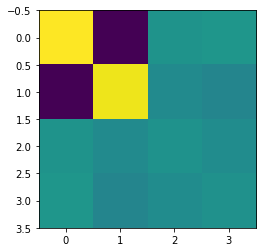

 11.8995   -11.5645   0.457265   0.784267  
-11.5645    11.3061  -0.318514  -0.876893  
0.457265  -0.318514   0.410643  -0.160629  
0.784267  -0.876893  -0.160629   0.259431  


In [75]:
correlation_matrix = compute_M_cal(n,p,Dc,M_mean, True)
matprint(correlation_matrix)

## 3ème étape
Let's compute optimal labels

In [76]:
# a revoir ?

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated):
    """
    Evalue le label y pour une tache t pour 2 classes
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    power_dc = power_diagonal_matrix(Dc, -1/2)
    et1_et2 = np.zeros((nb_tasks*nb_classes,1))
    y = np.zeros((nb_tasks*nb_classes, 1))
    e3_e4 = np.zeros((nb_tasks*nb_classes,1))
    e3_e4[-2] = 1
    e3_e4[-1] = -1
#     for t in range(nb_tasks):
#         et1_et2 = np.zeros((nb_tasks*nb_classes,1))
#         for l in range(nb_classes):
#             #print(t*nb_tasks+l)
#             et1_et2[t*nb_tasks+l] = 1 if l == 0 else -1
#         #print(et1_et2)
#         y[t*nb_tasks] = (power_dc.dot(inverse).dot(M_estimated).dot(power_dc).dot(et1_et2))[t*nb_tasks]
#         y[t*nb_tasks+1] = (power_dc.dot(inverse).dot(M_estimated).dot(power_dc).dot(et1_et2))[t*nb_tasks+1]
    y[-2] += (power_dc.dot(inverse).dot(M_estimated).dot(power_dc).dot(e3_e4))[-2]
    y[-1] += (power_dc.dot(inverse).dot(M_estimated).dot(power_dc).dot(e3_e4))[-1]
    return y
#malik's formula:
#tilde_y=(diag(c)*MM*diag(c)/co+diag(c))\((e3-e4)'*MM*diag(c))';
#\ : pour résoudre un systeme A\B => x solution de Ax=B

In [77]:
y = label_evaluation(t,m,Dc,correlation_matrix)
print("optimal labels for a 2-task 2-class example with synthetic gaussian data : ")
matprint(y)
y.shape

optimal labels for a 2-task 2-class example with synthetic gaussian data : 
       0  
       0  
 16.5816  
-11.3471  


(4, 1)

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [78]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_tasks+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

In [79]:
for k in range(t):
    for l in range(m):
        print(f"m_kl = {asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l)}")

m_kl = -0.07906060220389861
m_kl = 0.28027215526770616
m_kl = 2.3173865133091063
m_kl = -1.5053904217489484


## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [80]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

In [81]:
X_train_aggregated = aggregate_array(X, p, n, t, m)
X_test_aggregated = aggregate_array(X_test, p, n, 1, m)


In [82]:
# verification 
# ca semble bon

# print(X_test_aggregated[0:2])
# print(X_test[0][0][0][0:5])
# print(X_test[0][1][0][-2])

$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [83]:
def create_J(nb_classes, nb_tasks, n, n_t):
    # enlever paramètre n
    left = 0
    beg = 0
    for i in range(nb_tasks):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_classes))
    #matprint(J)
    for t in range(nb_tasks):
        for j in range(nb_classes):
            for i in range(beg, beg+n_t[t][j]):
                J[i][t*nb_tasks+j] = 1
            beg += n_t[t][j]
    return J

In [84]:
def compute_V_old(y_tilde, X, J):
    """
    Utilise la formule explicite de V pour la classification binaire
    """
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

def compute_V(y, X, J, n):
    """
    Recalcule V (calcul vecteur propre)
    Vstar dans le fichier matlab
    Division par p, si les X pas normalisé ?
    wtf is wrong with V? 
    """
    #X*J*(tilde_y*tilde_y')*J'*X'/n
    #print(X.shape)
    eigenvalue, V = np.linalg.eig(X.dot(J).dot((y).dot(y.T)).dot(J.T).dot(X.T)/(n))
    maximum = eigenvalue[0]
    idx_larg = 0
    # retrieve the index of the largest eigenvalue
    for idx, value in enumerate(eigenvalue):
        if value > maximum:
            maximum = value
            idx_larg = idx
    
    largest_eigenvalue = np.sort(eigenvalue.real)[-1]
    #print(largest_eigenvalue)
    #print(maximum)
    return V.T[idx_larg].real

In [85]:
J = create_J(m, t, n, n_t)
#matprint(J)
# revoir J
#x = np.random.normal(0, 1, size=(p,1))
#compute_score(y, J, X, x)
compute_V_old(y, X_train_aggregated, J)[0:3]

array([[-0.01055125],
       [-0.0068712 ],
       [-0.08895414]])

In [86]:
V = compute_V(y, X_train_aggregated, J, n)
V.shape
print(V[0:3])

[-0.01055125 -0.0068712  -0.08895414]


## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [87]:
def create_mt(t, m, y, Dc, correlation_matrix):
    m_t = []
    for k in range(t):
        m_tj = []
        for l in range(m):
            m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l))
        m_t.append(m_tj)

    return m_t

In [88]:
m_t = create_mt(t, m, y, Dc, correlation_matrix)
print(m_t)

[[-0.07906060220389861, 0.28027215526770616], [2.3173865133091063, -1.5053904217489484]]


In [89]:
def compute_score(V, x, m_t):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
    average_mean = 1/2*(m_t[0] + m_t[1])
    return (1 if x_projection > 0 else -1) 

In [90]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [91]:
def error_rate(m_t,nb_tasks, nb_classes, Dc, M_cur, c0):
    #return qfunc(1/2*(m_t[0] - m_t[1]))
    #quelle fonction prendre ?
    et1_et2 = np.zeros((2*nb_classes, 1))
    # seulement besoin de e3 et e4 étant donné que l'on teste les données de la task target
    et1_et2[2] = 1
    et1_et2[3] = -1
    e3 = np.zeros((2*nb_classes, 1))
    e3[2] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    inv = np.linalg.inv(M_cur+np.identity(2*2))
    et_trans = np.transpose(et1_et2)
    print("inverse : ", Dc.dot(M_cur).dot(Dc))
    print("c0Dc  : ", c0*Dc)
    print("arg q-func : ")
    print(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3))
    return qfunc(np.sqrt(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3)))
    #return qfunc(1/2*np.sqrt(et_trans.dot(power_dc).dot(M_cur).dot(inv).dot(M_cur).dot(power_dc).dot(et1_et2)))
#erfc(sqrt(e3'*MM*diag(c)*inv((diag(c)*MM*diag(c)+diag(co*c/k)))*diag(c)*MM*e3)/(sqrt(2)))/2;

In [92]:
def plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur):
    plt.scatter(1, emp_rate, label="empirical error")
    plt.scatter(1, [error_rate(m_t[1], nb_tasks, nb_classes, Dc, M_cur)], label="theoritical error")
    plt.grid()
    plt.ylim((0,1))
    plt.xlim((-0.5, 0.5))
    plt.legend()
    plt.title(f"Classification error rate per task")
    plt.show()

In [93]:
def compute_error_rate(X_test, V, m_t, nb_tasks, nb_classes, n_t, Dc, M_cur, c0, display = False):
    """
    Compute and plot classification error rate on test set
    """
    #print("n dans fonction: ", n)
    emp_rate = []
    error = 0
    ni = 0
    for t in range(nb_tasks):
        error = 0
        ni = sum(n_t[t])
        for l in range(nb_classes):
            for i in range(n_t[t][l]):
                # on prend la transposée pour pouvoir travailler avec les colonnes
                score = compute_score(V, np.transpose(X_test[t][l])[i], m_t[1])
                if (score == 1 and l == 1):
                    error +=1
                elif (score == -1 and l == 0):
                    error +=1
        
        erreur_emp = error/ni
        
        if erreur_emp > 0.5:
            erreur_emp=1-erreur_emp
        emp_rate.append(erreur_emp)
       
    if display:
        plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur)
    
    return np.mean(emp_rate), error_rate(m_t[1], nb_tasks, nb_classes,  Dc, M_cur, c0)[0][0]

In [94]:
compute_error_rate(X_test, V, m_t, t, m, n_t_test, Dc, correlation_matrix, p/n)

inverse :  [[ 2.45857840e+00 -2.38935892e+00  4.72381022e-03  8.10193173e-03]
 [-2.38935892e+00  2.33597479e+00 -3.29043862e-03 -9.05881493e-03]
 [ 4.72381022e-03 -3.29043862e-03  2.12109152e-04 -8.29696041e-05]
 [ 8.10193173e-03 -9.05881493e-03 -8.29696041e-05  1.34003520e-04]]
c0Dc  :  [[0.02066116 0.         0.         0.        ]
 [0.         0.02066116 0.         0.        ]
 [0.         0.         0.00103306 0.        ]
 [0.         0.         0.         0.00103306]]
arg q-func : 
[[0.1290925]]


(0.34750000000000003, 0.35968741163399487)

In [96]:
error_rate(m_t[1], t, m, Dc, np.transpose(M_mean).dot(M_mean), p/n)

inverse :  [[ 4.91715679e-01 -4.77871784e-01  4.22510431e-03  7.24658804e-03]
 [-4.77871784e-01  4.67194959e-01 -2.94305778e-03 -8.10245039e-03]
 [ 4.22510431e-03 -2.94305778e-03  8.48436609e-04 -3.31878417e-04]
 [ 7.24658804e-03 -8.10245039e-03 -3.31878417e-04  5.36014079e-04]]
c0Dc  :  [[0.02066116 0.         0.         0.        ]
 [0.         0.02066116 0.         0.        ]
 [0.         0.         0.00103306 0.        ]
 [0.         0.         0.         0.00103306]]
arg q-func : 
[[0.83540619]]


array([[0.18035696]])

In [97]:
def debug_histogram(V, X_test, n_t):
    """
    Trace l'histogramme de V^T*x_1 et V^T*x_2.
    """
#     print(X1[0][0])
#     print(n_t[0][0])
    alpha = 0.5
    bins = 20
    plt.hist(V.T.dot(X_test.T[:n_t[0][0]].T), bins = bins, alpha=alpha, label=r"$C_1$")
    plt.hist(V.T.dot(X_test.T[n_t[0][0]:].T), bins = bins, alpha=alpha, label=r"$C_2$")
    plt.title(r"Histogramme des données de tests projetées sur $V$ : $V^Tx_j$")
    plt.legend()
    plt.show()

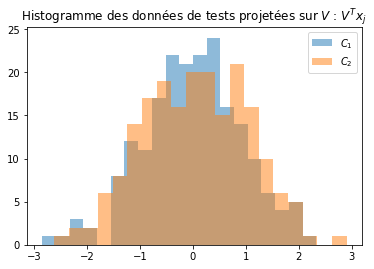

In [98]:
debug_histogram(V, X_test_aggregated, n_t_test)

# 2-class Gaussian mixture transfer (c.f. Figure 2)

class 0 empirical mean = 0.19249338591143622
class 1 empirical mean = -0.15542887590148635
class 2 empirical mean = 0.09245862478165584
class 3 empirical mean = -0.15887804909490447
MTM : 
[[ 2.51841682 -2.34649656  0.56877761  0.6344133 ]
 [-2.34649656  2.19735631 -0.35223124 -0.72907916]
 [ 0.56877761 -0.35223124  3.63314925 -2.19547195]
 [ 0.6344133  -0.72907916 -2.19547195  2.01129639]]
c =  [0.47619048 0.47619048 0.02380952 0.02380952]
Correlation Matrix : 
 12.5921   -11.7325   0.635913   0.709296  
-11.7325    10.9868  -0.393807  -0.815135  
0.635913  -0.393807   0.908287  -0.548868  
0.709296  -0.815135  -0.548868   0.502824  
y = 
      0  
      0  
26.4567  
-18.992  


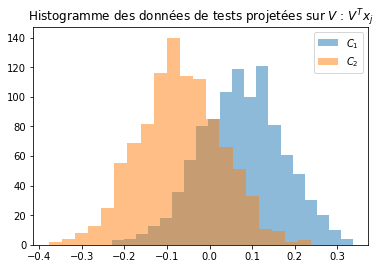

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.          0.        ]
 [-0.22675737  0.22675737  0.          0.        ]
 [ 0.          0.          0.00056689 -0.00056689]
 [ 0.          0.         -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.5]]
[0.231] [0.2397500610934767

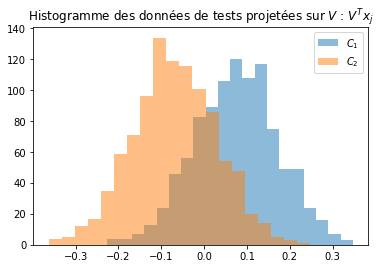

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00113379 -0.00113379]
 [-0.22675737  0.22675737 -0.00113379  0.00113379]
 [ 0.00113379 -0.00113379  0.00056689 -0.00056689]
 [-0.00113379  0.00113379 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.50239234]]
[0.231, 0.235] [0.23

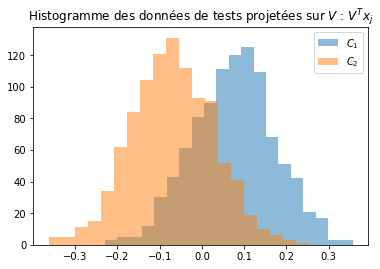

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00226757 -0.00226757]
 [-0.22675737  0.22675737 -0.00226757  0.00226757]
 [ 0.00226757 -0.00226757  0.00056689 -0.00056689]
 [-0.00226757  0.00226757 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.50970874]]
[0.231, 0.235, 0.231

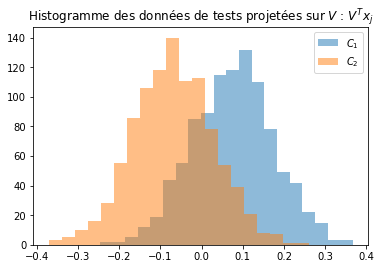

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00340136 -0.00340136]
 [-0.22675737  0.22675737 -0.00340136  0.00340136]
 [ 0.00340136 -0.00340136  0.00056689 -0.00056689]
 [-0.00340136  0.00340136 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.52238806]]
[0.231, 0.235, 0.231

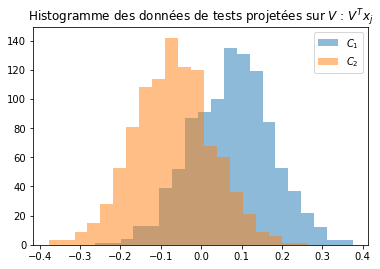

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00453515 -0.00453515]
 [-0.22675737  0.22675737 -0.00453515  0.00453515]
 [ 0.00453515 -0.00453515  0.00056689 -0.00056689]
 [-0.00453515  0.00453515 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.54123711]]
[0.231, 0.235, 0.231

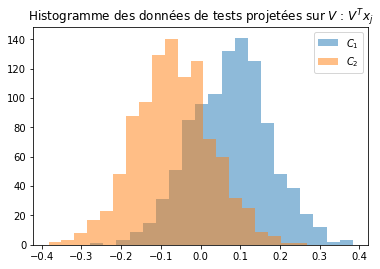

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00566893 -0.00566893]
 [-0.22675737  0.22675737 -0.00566893  0.00566893]
 [ 0.00566893 -0.00566893  0.00056689 -0.00056689]
 [-0.00566893  0.00566893 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.56756757]]
[0.231, 0.235, 0.231

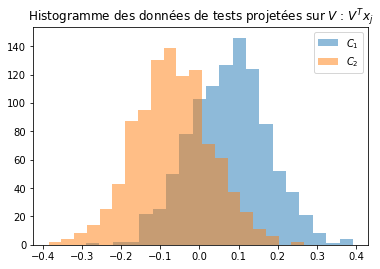

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00680272 -0.00680272]
 [-0.22675737  0.22675737 -0.00680272  0.00680272]
 [ 0.00680272 -0.00680272  0.00056689 -0.00056689]
 [-0.00680272  0.00680272 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.60344828]]
[0.231, 0.235, 0.231

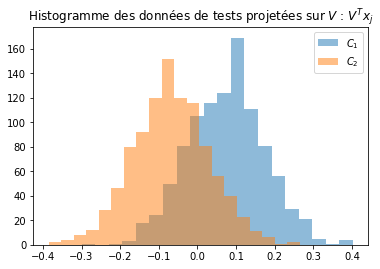

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00793651 -0.00793651]
 [-0.22675737  0.22675737 -0.00793651  0.00793651]
 [ 0.00793651 -0.00793651  0.00056689 -0.00056689]
 [-0.00793651  0.00793651 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.65217391]]
[0.231, 0.235, 0.231

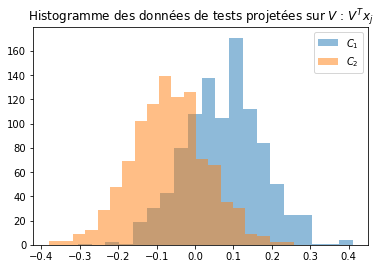

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.00907029 -0.00907029]
 [-0.22675737  0.22675737 -0.00907029  0.00907029]
 [ 0.00907029 -0.00907029  0.00056689 -0.00056689]
 [-0.00907029  0.00907029 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.71917808]]
[0.231, 0.235, 0.231

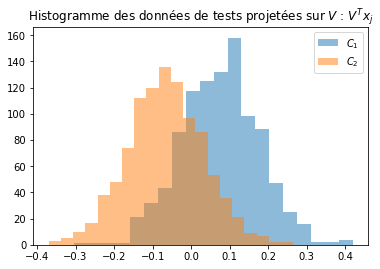

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.01020408 -0.01020408]
 [-0.22675737  0.22675737 -0.01020408  0.01020408]
 [ 0.01020408 -0.01020408  0.00056689 -0.00056689]
 [-0.01020408  0.01020408 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.81395349]]
[0.231, 0.235, 0.231

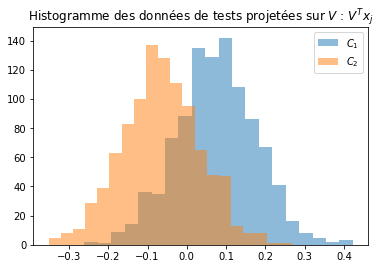

m_t =  [[0.09858827907021545, 0.14883511477625705], [4.530264391130005, -3.1649789619179556]]
inverse :  [[ 0.57106957 -0.53208539  0.00644873  0.00719289]
 [-0.53208539  0.49826674 -0.00399355 -0.0082662 ]
 [ 0.00644873 -0.00399355  0.00205961 -0.0012446 ]
 [ 0.00719289 -0.0082662  -0.0012446   0.00114019]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[2.61380559]]
inverse :  [[ 0.22675737 -0.22675737  0.01133787 -0.01133787]
 [-0.22675737  0.22675737 -0.01133787  0.01133787]
 [ 0.01133787 -0.01133787  0.00056689 -0.00056689]
 [-0.01133787  0.01133787 -0.00056689  0.00056689]]
c0Dc  :  [[0.02267574 0.         0.         0.        ]
 [0.         0.02267574 0.         0.        ]
 [0.         0.         0.00113379 0.        ]
 [0.         0.         0.         0.00113379]]
arg q-func : 
[[0.95454545]]
[0.231, 0.235, 0.231

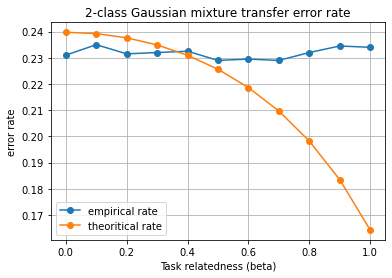

In [101]:
n = 2100
p = 100
m = 2
t = 2
beta = np.arange(0,1.1,0.1)
n_t = [[1000,1000], [50, 50]]
n_t_test = [[1000, 1000]]
emp_rate, th_rate = [], []
for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(b, p)
# #     print(M)
    X = gaussian_synthetic_data(n, p, m, t, n_t, M)
    X_test = gaussian_synthetic_data(n, p, m, 1, n_t_test, [M[1]])
    X = normalisation(X, p)
    X_test = normalisation(X_test, p)
#     X = normalisation_old(X, t, m)
#     Malik's normalization (dividing by sqrt(p))
#     X_train, X_test, n_t_train, n_t_test = train_test_split_data(X, 0.8, t, m)
#     y = create_labels(t,m)
    
    # On calcule les moyennes empiriques
    M_mean = empirical_mean(t, m, X_train, p, n_t_train)
    M_true = true_mean(M, p, t, m)
#     print("MTM : ")
    MM = np.transpose(M_mean).dot(M_mean)
    MM_true = np.transpose(M_true).dot(M_true)
#     print(MM)
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
#     print("c = ", c)
#     print("Correlation Matrix : ")
    correlation_matrix = compute_M_cal(n,p,Dc, M_mean, display=False)
    correlation_matrix_true = compute_M_cal(n,p,Dc, M_true, display=False)
#     matprint(correlation_matrix)
    y = label_evaluation(t,m,Dc,correlation_matrix)
    y_true = label_evaluation(t,m,Dc,correlation_matrix_true)
#     print("y = ")
#     matprint(y)
    X_train_aggregated = aggregate_array(X, p, n, t, m)
    X_test_aggregated = aggregate_array(X_test, p, sum(n_t_test[0]), 1, m)
    J = create_J(m, t, n, n_t)
    
    V = compute_V(y, X_train_aggregated, J, n)
    V_true = compute_V(y_true, X_train_aggregated, J, n)
    debug_histogram(V, X_test_aggregated, n_t_test)
#     print("V = ")
#     print(V)
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true)
#     print("m_t = ", m_t)
#     erreurs = compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, MM, c0)
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, MM, c0)[0])
    th_rate.append(compute_error_rate(X_test, V_true, m_t_true, 1, m, n_t_test, Dc, MM_true, c0)[1])

    print(emp_rate, th_rate)
    
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [ ]:
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [ ]:
np.transpose(M_mean).dot(M_mean)

# Algorithme distribué 2 tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.

### Serveur isolé

In [ ]:
n = 2000
p = 100
m = 2
t = 1
n_t = [[1000,1000]]
M = mean_random_matrix(m, t, p, 0., 0.5)
X = gaussian_synthetic_data(n, p, m, t, n_t, M)
X_train, X_test, n_t_train, n_t_test = train_test_split_data(X, 0.8, t, m)
y = create_labels(t,m)
M_mean = empirical_mean(t, m, X_train, p, n_t_train)
c = estimate_c(n_t, n, t, m)
Dc = np.diag(c)
correlation_matrix = compute_M_cal(n,p,Dc,M_mean, display=True)
y = label_evaluation(t,m,Dc,correlation_matrix)
X_train_aggregated = aggregate_array(X_train, p, n, t, m)
X_test_aggregated = aggregate_array(X_train, p, n, t, m)
J = create_J(m, t, n, n_t_train)
V = compute_V(y, X_train_aggregated, J)
m_t = create_mt(t, m, y, Dc, correlation_matrix)
compute_error_rate(X_test, V, m_t, t, m, n_t_test, Dc, correlation_matrix, True)

### 2 serveurs 
L'un des serveurs va demander les moyennes de l'autre pour entraîner le modèle sur ses données et sortir un résultat. 

L'autre serveur pourrait envoyer sa matrice de corrélation $\mathcal{M}\in\mathbb{R}^{km\times km}$ et le serveur demandant utiliserait une matrice de corrélation moyennée et pondérée par les poids de chaque dataset (si un dataset est plus grand que l'autr, il faut évidemment le prendre en compte) entre les deux matrices de corrélation.

Enfait, non il faut envoyer les moyennes empiriques de chaque classe dans chaque tache (=chaque client) pour pouvoir ensuite calculer $\mathcal{M}$, car il nous faut aussi les produits scalaires entre les moyennes des différentes tâches.

Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

Chaque client calcule en local les moyennes empiriques des données et les envoie au serveur central.

De la même façcon que précédemment les données de chaque client (=chaque tâche) devront respecter les conditions de non-trivialité.

In [ ]:
def average_correlation_matrix(nb_tasks, nb_classes, matrices, weights):
    """
    Renvoie une matrice de corrélation moyennée et pondérée à partir des différentes matrices de corrélation en input.
    matrices est un tableau de matrice 2x2
    weights est un tableau avec les différents poids des datasets (i.e. n le nombre de samples dans le dataset)
    """
    nb_matrices = len(matrices)
    size = nb_classes*nb_tasks
    averaged_M = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            for idx, mat in enumerate(matrices):
                averaged_M[i][j] += mat[i][j]
            averaged_M[i][j] /= nb_matrices

    return averaged_M

In [ ]:
def create_clients(k, m):
    """
    Retourne k datasets à m classes gaussiens représentant les k taches  
    """
    pass

In [ ]:
def central_server(emp_means, k):
    """
    Retourne les taux d'erreur après utilisation des données de tous les clients
    """
    pass

In [ ]:
# pas fait le cas du j=j' mais j'ai pas l'impression que c'est nécessaire en tout cas pas ici ?
# cf remark 1

def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data X
    return an 1xp vector being the empirical mean for the random vector X_{tj}
    retourne la matrice M
    """
    M = np.empty((nb_classes*nb_tasks, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            print(X[t][l].dot(np.ones((n_t[t][l]))).shape)
            # print(t*nb_classes+l)
            M[t*nb_tasks+l] = X[t][l].dot(np.ones((n_t[t][l])))
            M[t*nb_tasks+l] /= n_t[t][l]
            #print(f"class {t*nb_tasks+l} empirical mean = {np.mean(M[t*nb_tasks+l])}")
    return np.transpose(M)

def empirical_mean(nb_tasks, nb_classes, X, p, n_t):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    M = np.empty((nb_classes*nb_tasks, p))
    for i in range(nb_classes)
    return M.T

In [ ]:
def gather_empirical_mean(k, p, emp_means):
    """
    Crée la fonction M (p*2k) avec les moyennes empiriques des différents clients
    avec k le nombre de clients(+serveur central)
    emp_means est un tableau de taille k qui contient toutes les moyennes empiriques (serveur compris)
    """
    M = np.empty((2*k, p))
    for idx, mean in enumerate(emp_means):
        mean = np.reshape(mean, (100))
        print(mean.shape)
        M[idx] = mean
    return M.T

In [ ]:
n = 2100
p = 100
m = 2
t = 1
n_t = [[1000,1000], [50, 50]]
# s'assurer des conditions de non trivialité entre les moyennes des différentes tâches
M = mean_random_matrix(m, t, p, 0., 0.5)
M1 = np.zeros((p, 1))
M2 = np.zeros((p, 1))
M1[-1] = 1
M2 = -M1
X = gaussian_synthetic_data(n, p, m, t, n_t, M)
X_test = gaussian_synthetic_data(n, p, m, t, n_t, [M1, M2]) # ?
#X_train, X_test, n_t_train, n_t_test = train_test_split_data(X, 0.8, t, m)
#y = create_labels(t,m)
# on calcule les moyennes empiriques des données locales
M_mean = empirical_mean(t, m, X_train, p, n_t_train)
# on crée la matrice des moyennes empiriques locales et externes
M_gathered = gather_empirical_mean(2, p, [M[0][0], M[0][1], M1, M2])
c = estimate_c(n_t, n, 2, m)
Dc = np.diag(c)
correlation_matrix = compute_M_cal(n,p,Dc,M_gathered, display=True)
matprint(correlation_matrix)
# on calcule les labels optimaux à partir de la matrice de corrélation issue des données locales et externes
y = label_evaluation(2,m,Dc,correlation_matrix) 
X_train_aggregated = aggregate_array(X, p, n, t, m)
X_test_aggregated = aggregate_array(X_test, p, n, t, m)

# Le serveur central (qui peut aussi être un client) envoie maintenant la donnée x qu'il souhaite tester aux clients (a-t-il le droit d'envoyer une donnée x de la sorte ?)
# Chaque client calcule le score à partir de x

# Il faut créer les données locales de chaque clients
# Il faut aussi avoir accès à la matrice M cursive qui reste pareil, sauf lorsque le client recoit une update du serveur central

X1 = gaussian_synthetic_data(n, p, m, t, n_t[1], M1)
J1 = create_J(m, 1, n, n_t[1])
V1 = compute_V(y, X1, J1)
m_t = create_mt(t, m, y, Dc, correlation_matrix)
# On calcule le score en local
compute_error_rate(X_test, V1, m_t, t, m, n_t_test, Dc, correlation_matrix1)

# on ajoute les longueurs des données externes
n_t_train.append(n_t[1])
J = create_J(m, 2, n, n_t_train)
V = compute_V(y, X_train_aggregated, J)
m_t = create_mt(2, m, y, Dc, correlation_matrix)
compute_error_rate(X_test, V, m_t, 2, m, n_t_test, Dc, correlation_matrix, True)

$(1/n_{tj})\sum_{m=1}^{n_{tj}} x^{(t)}_{jm}$

In [ ]:
print(n_t_train)